In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency


plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('preprocessed_fire_data_clean.csv')

In [3]:
print(f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

Dataset: 200,000 rows × 22 columns


In [4]:
df.head()

,latitude,longitude,bright_ti4,scan,track,satellite,instrument,confidence,version,bright_ti5,...,month,day_of_year,week_of_year,season,is_fire_season,is_daytime,acq_hour,is_afternoon,region,severity_class
0,-12.07912,134.55260,342.99,0.45,0.47,N,VIIRS,75,2,301.02,...,6,180,26,Winter,0,1,5,0,North,1
1,-15.75430,129.01073,340.15,0.37,0.58,N,VIIRS,75,2,311.96,...,11,320,46,Spring,1,1,4,0,North,0
2,-21.43215,117.24640,340.71,0.50,0.41,N,VIIRS,75,2,303.82,...,6,158,23,Winter,0,1,6,0,Central,2
3,-17.89678,130.74759,335.57,0.49,0.65,N,VIIRS,75,2,299.00,...,4,111,16,Autumn,0,1,4,0,North,0
4,-24.16475,151.12544,337.86,0.37,0.58,N,VIIRS,75,2,302.75,...,10,294,42,Spring,0,1,4,0,Central,0


### Target Variable:

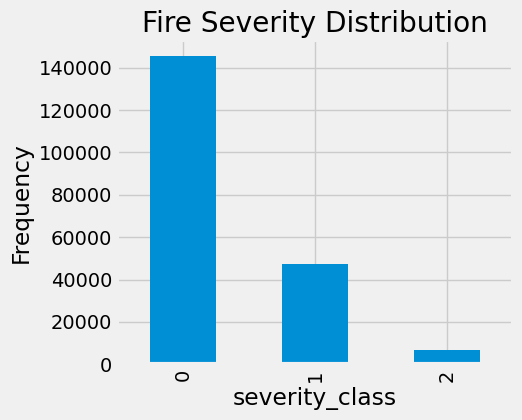

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df['severity_class'].value_counts().plot(kind='bar')
plt.title('Fire Severity Distribution')
plt.ylabel('Frequency')
plt.show()

### Functions for EDA:

In [6]:
# Function for numerical analysis: (Univariate Analysis)
def numerical_analysis(df,numerical_feature,categorical_feature=None):
    
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(10,5))

    # KDE and boxplot for the numerical features:
    sns.kdeplot(x=df[numerical_feature],fill=True,color='purple',ax=ax[0],hue=categorical_feature)
    sns.boxplot(x=df[numerical_feature],color='red',linewidth=0.7,ax=ax[1],hue=categorical_feature)

    # Statistics for the numerical features:
    mean=df[numerical_feature].mean()
    median=df[numerical_feature].median()
    std=df[numerical_feature].std()
    skew=df[numerical_feature].skew()

    stats_text=(
        f"Mean:{round(mean,2)}\n"
        f"Median:{round(median,2)}\n"
        f"Std:{round(std,2)}\n"
        f"skew:{round(skew,2)}"
    )
    
    ax[0].text(
        0.98,0.98,
        stats_text,
        ha='right',
        va='top',
        transform=ax[0].transAxes,
        bbox=dict(facecolor='white', alpha=0.7,edgecolor='black',linewidth=1.5),
        fontsize=10
    )

    plt.tight_layout()
    plt.show()

In [7]:
def categorical_categorical_analysis_simple(df: pd.DataFrame, cat1: str, cat2: str) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    cross_tab = pd.crosstab(df[cat1], df[cat2])
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', ax=ax[0])
    ax[0].set_title(f'{cat1} vs {cat2}\nFrequency Heatmap')
    
    # 2. Stacked percentage bar plot
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    cross_tab_pct.plot(kind='bar', stacked=True, ax=ax[1], colormap='Set3')
    ax[1].set_title(f'{cat1} vs {cat2}\nPercentage Distribution')
    ax[1].set_ylabel('Percentage (%)')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [8]:
#Multivariate Analysis:
def multivariate_analysis(df,cat_col1,cat_col2,num_col=None):
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))

    # Violin Plot and barplot for the categorical features:
    sns.violinplot(x=df[cat_col1],y=df[num_col],hue=df[cat_col2],color='purple',ax=ax[0])
    sns.barplot(x=df[cat_col1],y=df[num_col],hue=df[cat_col2],color='red',linewidth=0.7,ax=ax[1])

    ax[0].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.show()

In [9]:
# Function to check normality:
def normality_check(df,feature,alpha=0.05):
    
    stat,p_value=stats.jarque_bera(df[feature])
    print(f"The p_value is:{p_value}")

    if p_value<=alpha:
        print("Reject Null Hypothesis. The data is not normally distributed")
    else:
        print("Fail to reject Null Hypothesis. The data is normally distributed")

# ANOVA:
def anova_test(df:pd.DataFrame, num_col, cat_col,alpha=0.05):
    data=df.loc[:,[num_col,cat_col]].dropna()

    cat_group=df.groupby(cat_col)
    groups=[group[num_col].values for _,group in cat_group]
    f_stat,p_value=stats.f_oneway(*groups)
    print(p_value)

    if p_value<=alpha:
        print(f"Reject null hypothesis. There is a significant relationship between {num_col} and {cat_col}")
    else:
        print(f"Fail to reject null hypothesis. There is no significant relationship between {num_col} and {cat_col}")

#Chi-Sqaure test:
def chiq_square(df:pd.DataFrame,cat_col1,cat_col2,alpha=0.05):
    data=df.loc[:,[cat_col1,cat_col2]]
    contingency_table=pd.crosstab(data[cat_col1],data[cat_col2])
    test_stats,p_value,_,_=stats.chi2_contingency(contingency_table)
    print(p_value)
    if p_value<alpha:
        print(f"Reject Null Hypothesis. There is significant associaion between {cat_col1} and {cat_col2}")
    else:
        print(f"Fail to reject Null Hypothesis. There is no significant associaion between {cat_col1} and {cat_col2}")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitude        200000 non-null  float64
 1   longitude       200000 non-null  float64
 2   bright_ti4      200000 non-null  float64
 3   scan            200000 non-null  float64
 4   track           200000 non-null  float64
 5   satellite       200000 non-null  object 
 6   instrument      200000 non-null  object 
 7   confidence      200000 non-null  int64  
 8   version         200000 non-null  int64  
 9   bright_ti5      200000 non-null  float64
 10  daynight        200000 non-null  object 
 11  year            200000 non-null  int64  
 12  month           200000 non-null  int64  
 13  day_of_year     200000 non-null  int64  
 14  week_of_year    200000 non-null  int64  
 15  season          200000 non-null  object 
 16  is_fire_season  200000 non-null  int64  
 17  is_daytime

UNIVARIATE ANALYSIS


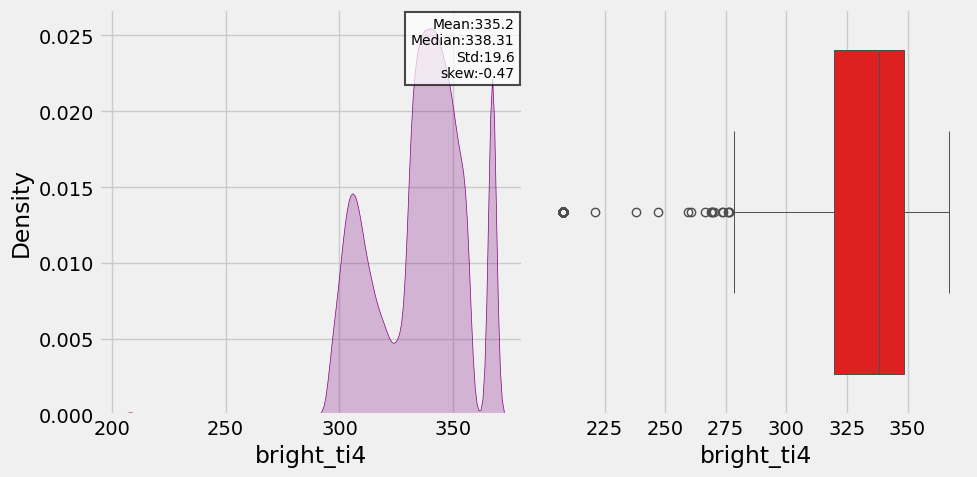

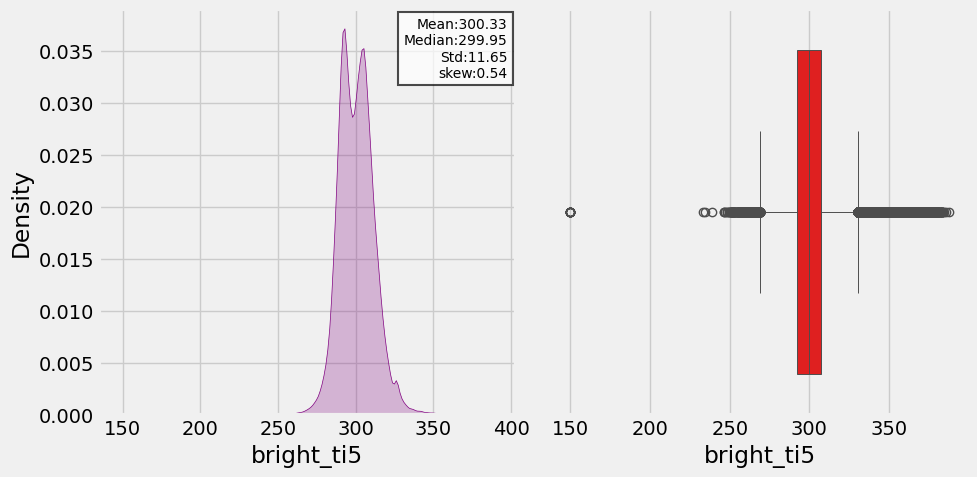

In [11]:
print("UNIVARIATE ANALYSIS")

# Most important numerical features for bushfire analysis
key_numerical = ['bright_ti4', 'bright_ti5']

for feature in key_numerical:
    numerical_analysis(df, feature)

In [12]:
df[df['bright_ti5']==150]

,latitude,longitude,bright_ti4,scan,track,satellite,instrument,confidence,version,bright_ti5,...,month,day_of_year,week_of_year,season,is_fire_season,is_daytime,acq_hour,is_afternoon,region,severity_class
13968,-13.18529,131.85274,355.76,0.44,0.38,N,VIIRS,75,2,150.0,...,8,216,31,Winter,0,0,16,1,North,1
23934,-15.92939,144.12828,328.70,0.33,0.55,N,VIIRS,75,2,150.0,...,11,306,44,Spring,1,0,15,1,North,0
92730,-19.85226,138.80733,350.44,0.60,0.70,N,VIIRS,75,2,150.0,...,11,306,44,Spring,1,0,15,1,North,1
100768,-29.00674,151.79567,342.32,0.41,0.37,N,VIIRS,75,2,150.0,...,11,306,44,Spring,1,0,15,1,South,0
123052,-28.12200,152.32394,320.08,0.42,0.38,N,VIIRS,75,2,150.0,...,11,306,44,Spring,1,0,15,1,South,0
128592,-15.90671,144.13058,323.37,0.33,0.55,N,VIIRS,75,2,150.0,...,11,306,44,Spring,1,0,15,1,North,1
128769,-29.11596,151.80443,341.76,0.41,0.37,N,VIIRS,75,2,150.0,...,11,306,44,Spring,1,0,15,1,South,0
141124,-19.45630,142.24335,327.97,0.37,0.58,N,VIIRS,75,2,150.0,...,11,306,44,Spring,1,0,15,1,North,0
142924,-25.22300,147.72021,331.14,0.44,0.38,N,VIIRS,75,2,150.0,...,11,306,44,Spring,1,0,15,1,Central,0
174256,-19.80120,139.13493,329.16,0.57,0.69,N,VIIRS,75,2,150.0,...,11,306,44,Spring,1,0,15,1,North,0


In [13]:
df[df['bright_ti4']<225]

,latitude,longitude,bright_ti4,scan,track,satellite,instrument,confidence,version,bright_ti5,...,month,day_of_year,week_of_year,season,is_fire_season,is_daytime,acq_hour,is_afternoon,region,severity_class
2896,-34.89761,146.98080,208.0,0.42,0.61,N,VIIRS,50,2,316.62,...,4,116,17,Autumn,0,1,4,0,South,2
3237,-35.39920,142.58023,208.0,0.35,0.57,N,VIIRS,50,2,313.83,...,4,94,14,Autumn,0,1,5,0,South,2
4670,-37.62207,148.74428,208.0,0.39,0.36,N,VIIRS,50,2,319.92,...,1,4,1,Summer,1,1,4,0,South,2
5234,-18.91677,129.66298,208.0,0.60,0.71,N,VIIRS,50,2,323.23,...,1,9,1,Summer,1,1,4,0,North,2
6018,-16.03573,136.43336,208.0,0.42,0.61,N,VIIRS,50,2,310.12,...,8,229,33,Winter,0,1,3,0,North,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194116,-19.04548,135.21356,208.0,0.35,0.56,N,VIIRS,50,2,321.14,...,10,282,41,Spring,0,1,3,0,North,2
196343,-20.55176,123.69991,208.0,0.64,0.72,N,VIIRS,50,2,321.80,...,3,69,10,Autumn,0,1,6,0,Central,2
198492,-35.52262,146.37642,208.0,0.55,0.68,N,VIIRS,50,2,302.46,...,4,107,15,Autumn,0,1,5,0,South,2
198620,-37.42131,142.45090,208.0,0.55,0.68,N,VIIRS,50,2,302.31,...,12,353,51,Summer,1,1,3,0,South,2


In [14]:
df[(df['bright_ti4']<225) & (df['bright_ti5']==150)]

,latitude,longitude,bright_ti4,scan,track,satellite,instrument,confidence,version,bright_ti5,...,month,day_of_year,week_of_year,season,is_fire_season,is_daytime,acq_hour,is_afternoon,region,severity_class


BIVARIATE ANALYSIS (NUMERICAL VS CATEGORICAL)
Relationship: region vs severity_class


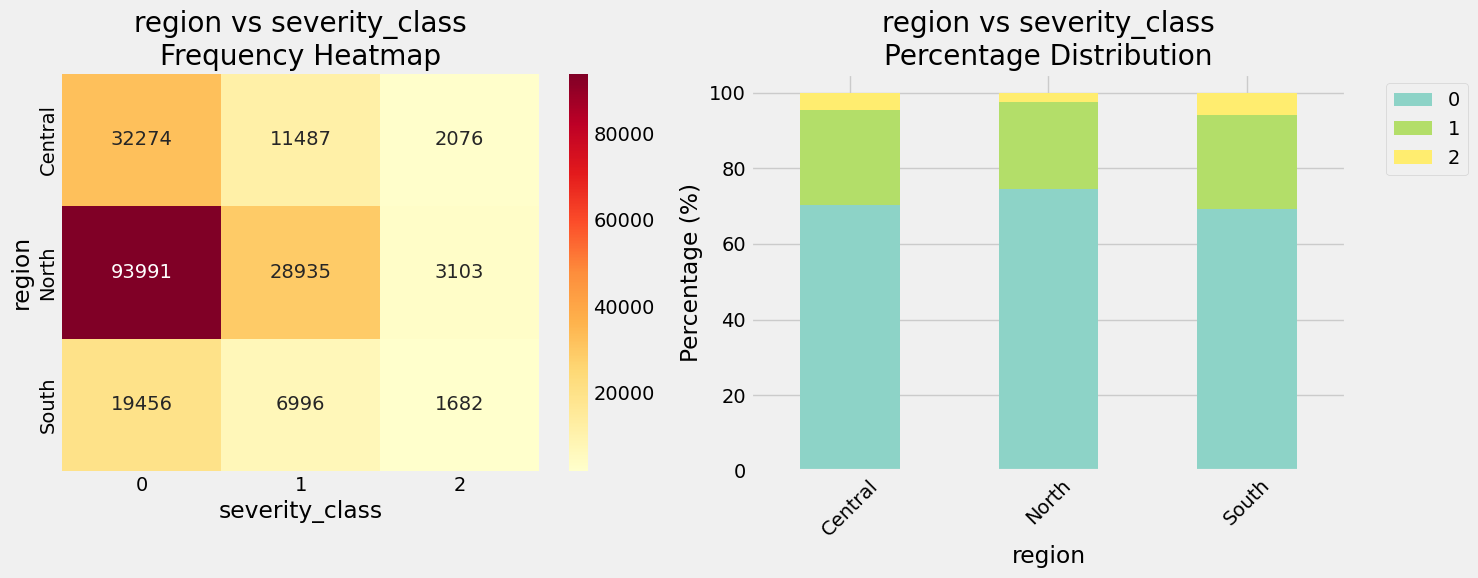

Relationship: season vs severity_class


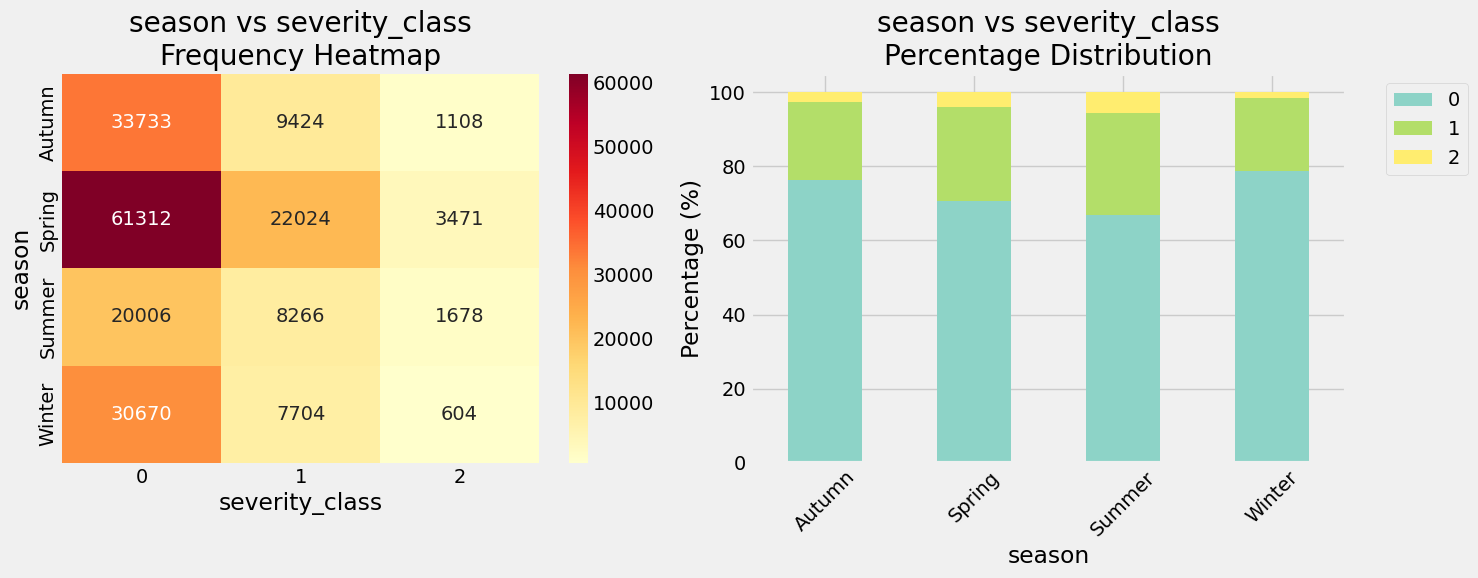

Relationship: daynight vs severity_class


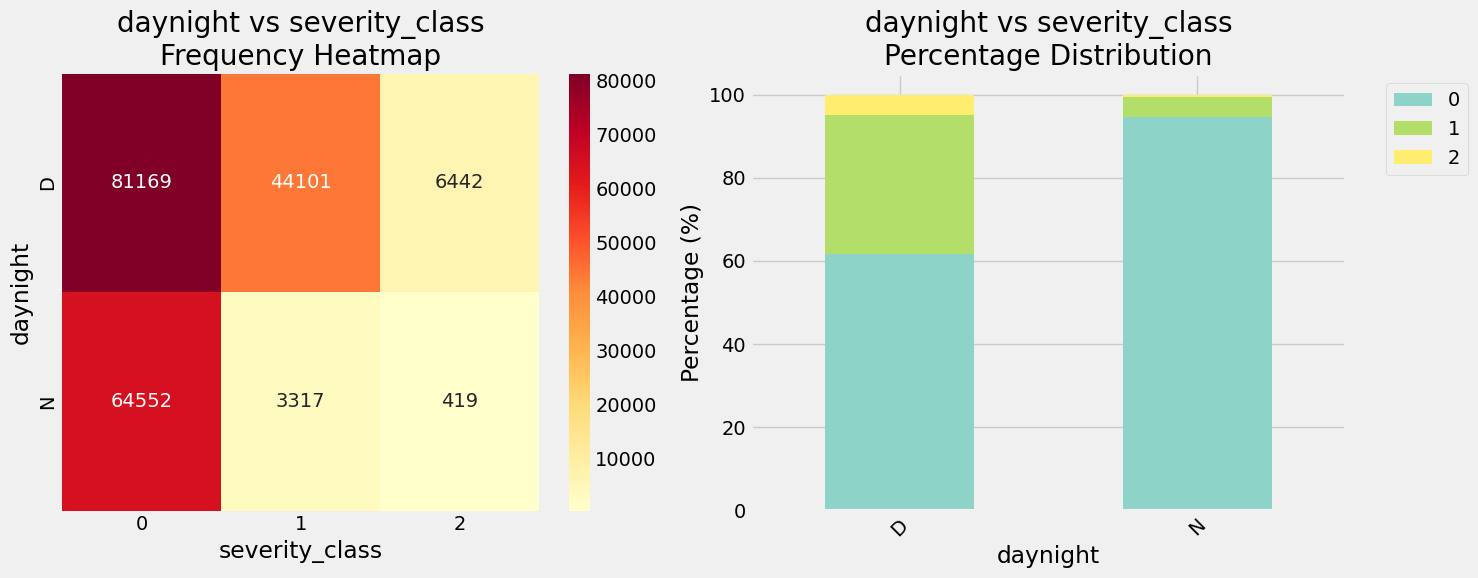

Relationship: is_fire_season vs severity_class


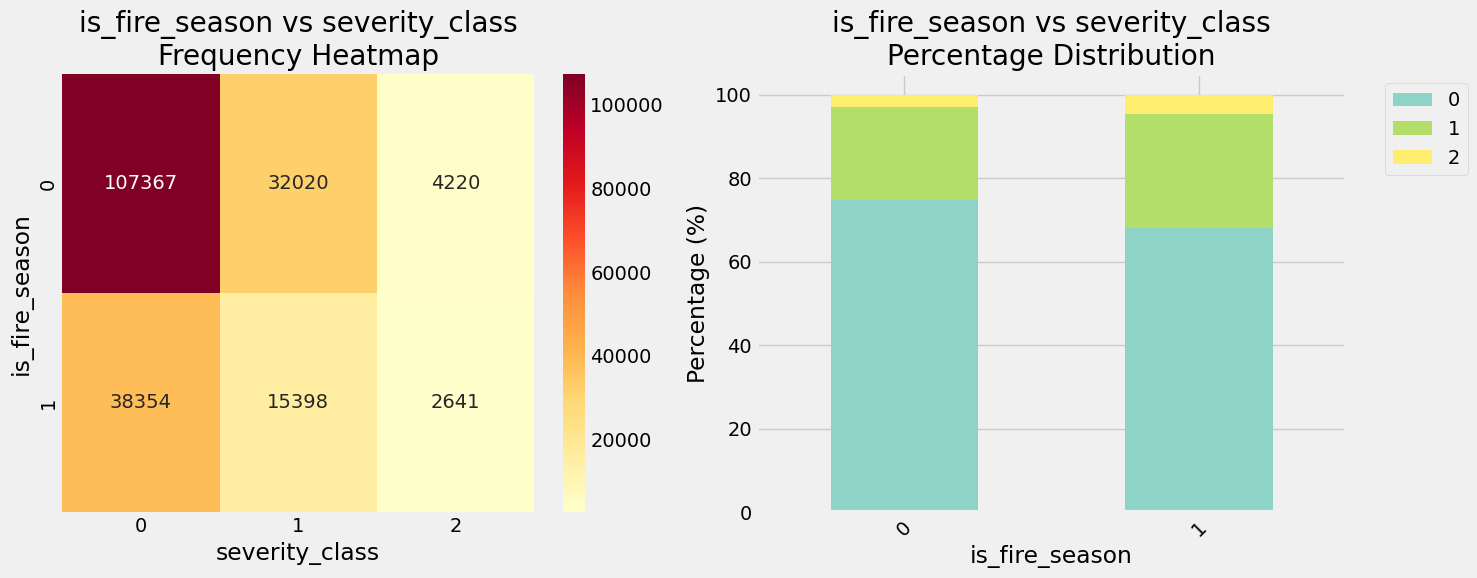

In [15]:
print("BIVARIATE ANALYSIS (NUMERICAL VS CATEGORICAL)")

relationships = [
    ('region', 'severity_class'),
    ('season', 'severity_class'),
    ('daynight', 'severity_class'),
    ('is_fire_season', 'severity_class'),
]

for cat_col1, cat_col2 in relationships:
    print(f"Relationship: {cat_col1} vs {cat_col2}")
    categorical_categorical_analysis_simple(df, cat_col1, cat_col2)

In [16]:
print("STATISTICAL TESTS (ANOVA)")
anova_tests = [
    ('bright_ti4', 'severity_class'),
    ('year', 'severity_class'),
    ('acq_hour', 'severity_class'),
    ('bright_ti5','severity_class' )
]

for num_col, cat_col in anova_tests:
    anova_test(df, num_col, cat_col)

STATISTICAL TESTS (ANOVA)
0.0
Reject null hypothesis. There is a significant relationship between bright_ti4 and severity_class
9.476588463357425e-09
Reject null hypothesis. There is a significant relationship between year and severity_class
0.0
Reject null hypothesis. There is a significant relationship between acq_hour and severity_class
0.0
Reject null hypothesis. There is a significant relationship between bright_ti5 and severity_class


In [17]:
print("STATISTICAL TESTS (CHI-SQUARE)")

chi_tests = [
    ('region', 'severity_class'),
    ('season', 'severity_class'),
    ('daynight', 'severity_class'),
    ('is_fire_season', 'severity_class'),
]

for cat_col1, cat_col2 in chi_tests:
    chiq_square(df, cat_col1, cat_col2)

STATISTICAL TESTS (CHI-SQUARE)
8.55774120250711e-272
Reject Null Hypothesis. There is significant associaion between region and severity_class
0.0
Reject Null Hypothesis. There is significant associaion between season and severity_class
0.0
Reject Null Hypothesis. There is significant associaion between daynight and severity_class
9.000990506981665e-227
Reject Null Hypothesis. There is significant associaion between is_fire_season and severity_class


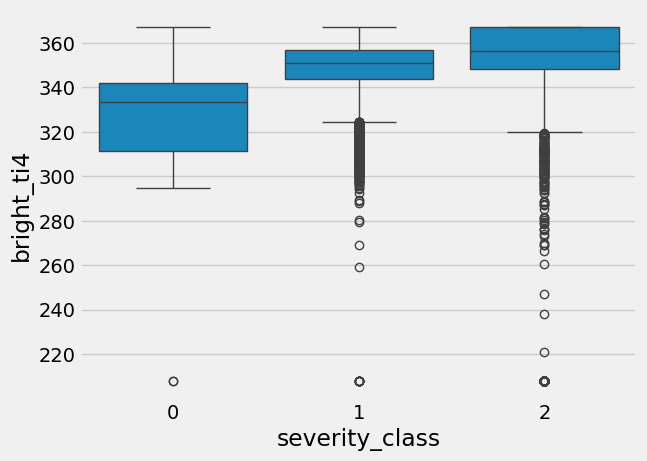

In [4]:
sns.boxplot(data=df,x='severity_class',y='bright_ti4')
plt.show()

In [18]:
num_col=[col for col in df.columns if df[col].dtype in ['int64','float64'] and col!='has_fire' and col!='version']

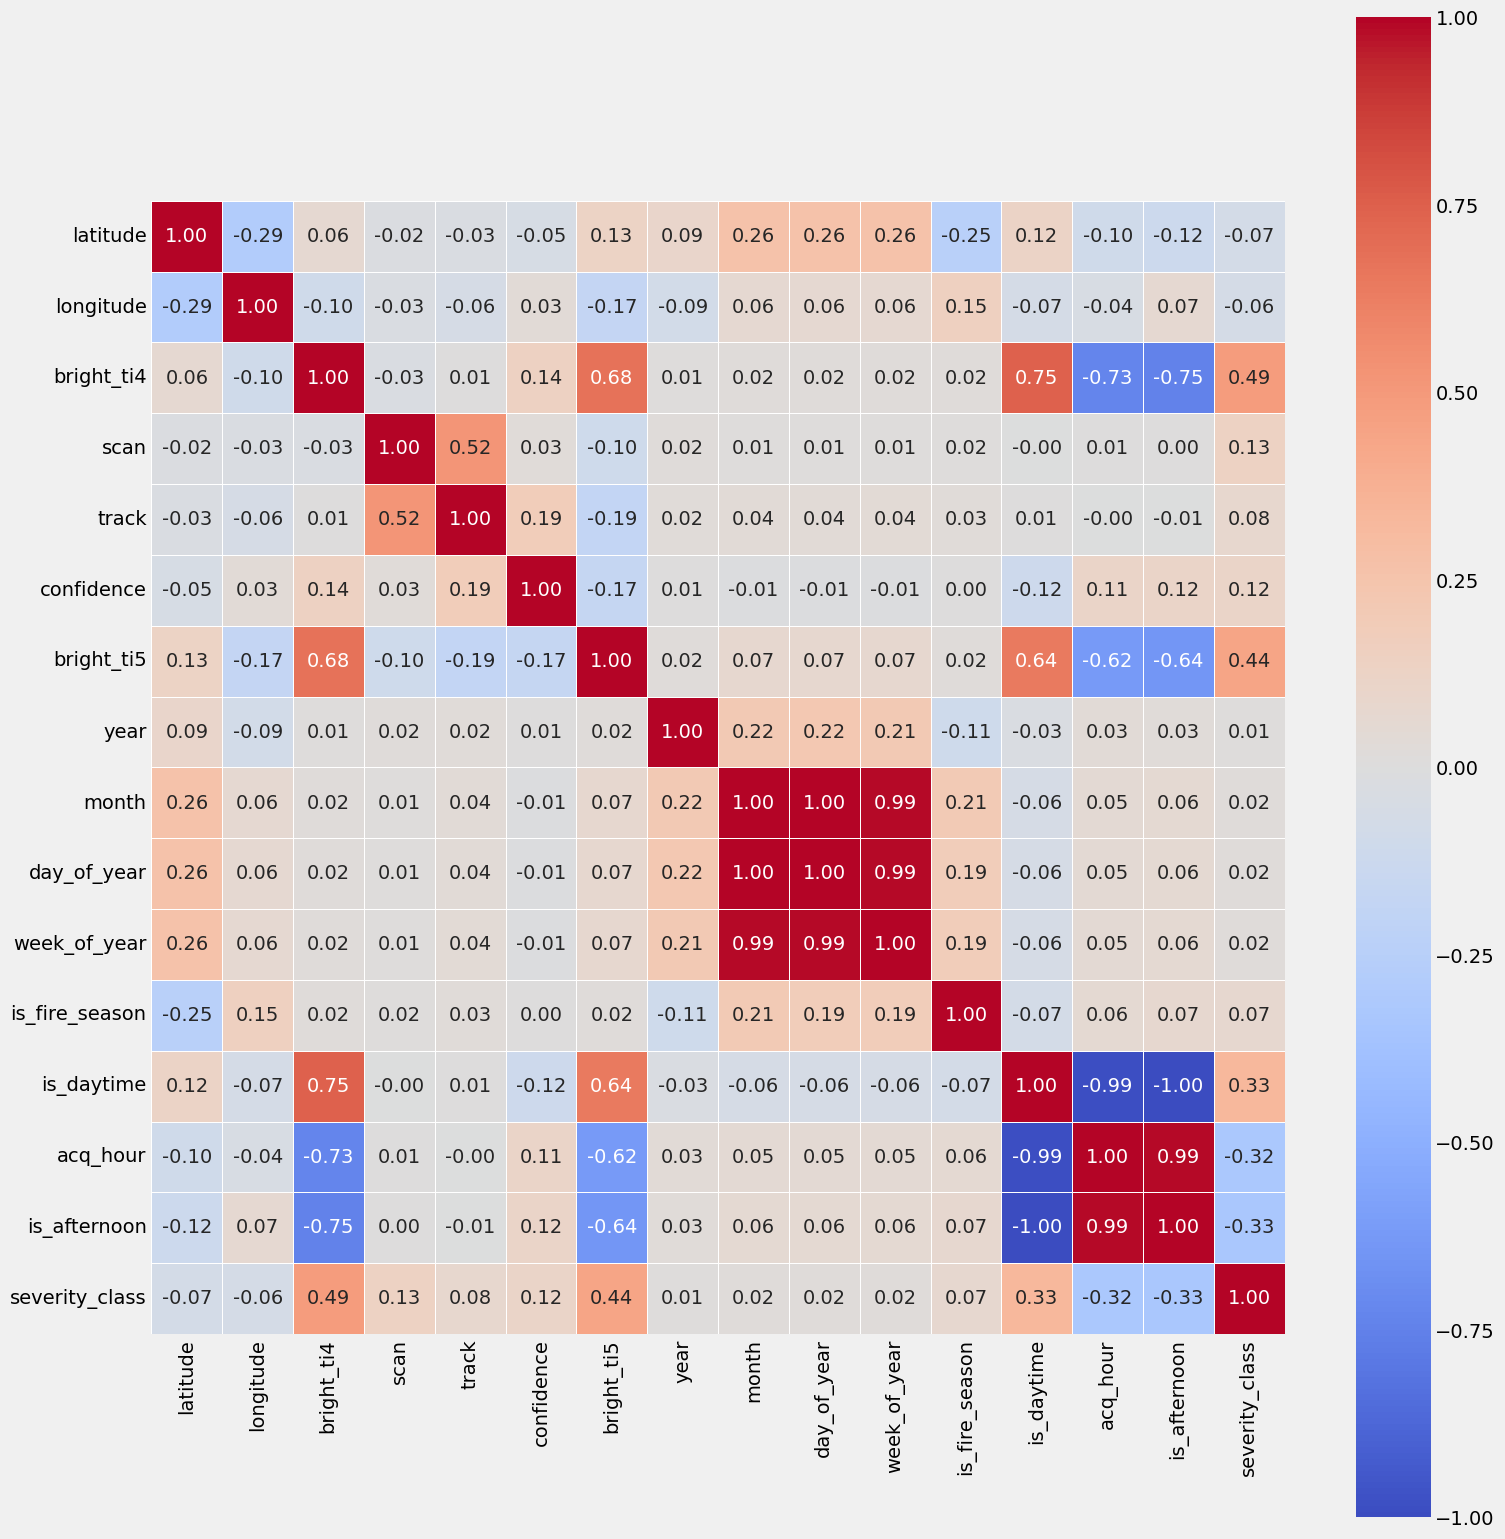

In [19]:
# Correlation heatmap for numerical features
plt.figure(figsize=(16, 16))
correlation_matrix = df[num_col].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5,fmt='.2f')
plt.tight_layout()
plt.show()